In [12]:
import pandas as pd
import matplotlib.pyplot as plt

In [8]:
df = pd.read_csv("NQ_from_2000.csv", sep= ";")

In [9]:
df.head()

,Date,Time,Open,High,Low,Close,Up,Down,PLOT1,PLOT2
0,01/03/2000,01:00,6975.5,6977.0,6975.5,6975.5,3,0,0.0,0.0
1,01/03/2000,02:00,6977.5,6979.5,6977.5,6979.5,2,0,-1.0,-1.0
2,01/03/2000,03:00,6979.5,6993.5,6979.5,6987.5,21,0,-1.0,-1.0
3,01/03/2000,04:00,6986.5,6994.5,6984.5,6992.5,16,0,-1.0,-1.0
4,01/03/2000,05:00,6994.5,6999.5,6993.5,6999.5,19,0,-1.0,-1.0


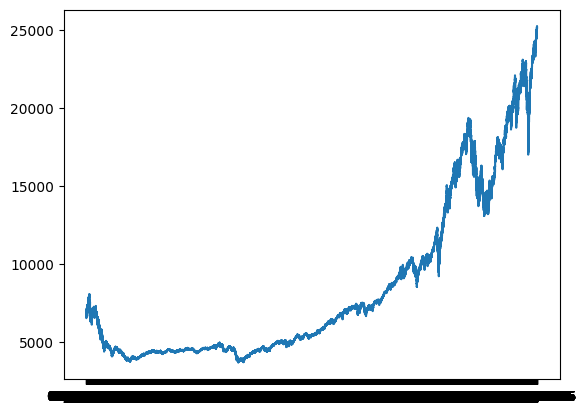

In [14]:
plt.plot( df["Date"], df["Open"],)
plt.show()